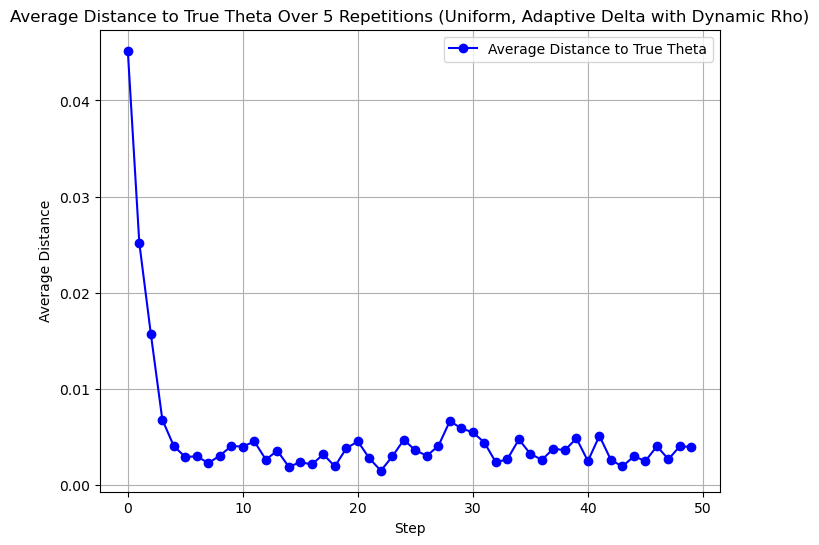

Step 0: Average Distance to True Theta = 0.045177
Step 1: Average Distance to True Theta = 0.025177
Step 2: Average Distance to True Theta = 0.015741
Step 3: Average Distance to True Theta = 0.006810
Step 4: Average Distance to True Theta = 0.004045
Step 5: Average Distance to True Theta = 0.002915
Step 6: Average Distance to True Theta = 0.002994
Step 7: Average Distance to True Theta = 0.002280
Step 8: Average Distance to True Theta = 0.003055
Step 9: Average Distance to True Theta = 0.004055
Step 10: Average Distance to True Theta = 0.004003
Step 11: Average Distance to True Theta = 0.004531
Step 12: Average Distance to True Theta = 0.002648
Step 13: Average Distance to True Theta = 0.003568
Step 14: Average Distance to True Theta = 0.001889
Step 15: Average Distance to True Theta = 0.002381
Step 16: Average Distance to True Theta = 0.002144
Step 17: Average Distance to True Theta = 0.003193
Step 18: Average Distance to True Theta = 0.001939
Step 19: Average Distance to True Theta =

In [9]:
# Adaptive delta: Adjusts the probability of selecting closer points based on distance differences
import numpy as np
import matplotlib.pyplot as plt

# Parameters
s = 1  # Scale parameter for uniform distribution
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m = 1000  # Number of samples in the first batch
n = 5*10**4  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 50  # Number of steps
delta_default = 0.8  # Default probability of selecting closer points
rho = 1  # Initial threshold for distance difference
k = 5  # Number of repetitions

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points with an adjusted delta probability
def probabilistic_filter_data(data1, data2, theta_vec, delta_default, rho):
    # Compute distances of points in both datasets to the true theta
    dist1 = np.linalg.norm(data1 - theta_vec, axis=1)
    dist2 = np.linalg.norm(data2 - theta_vec, axis=1)
    
    # Initialize selected data
    selected_data = []
    
    # Iterate through both datasets point by point
    for i in range(len(dist1)):
        # Adjust delta dynamically based on distance difference
        delta = delta_default if abs(dist1[i] - dist2[i]) >= rho else 0.5
        
        if dist1[i] < dist2[i]:
            # dist1 < dist2: Choose data1 with delta probability, otherwise choose data2
            if np.random.rand() < delta:
                selected_data.append(data1[i])
            else:
                selected_data.append(data2[i])
        else:
            # dist1 >= dist2: Choose data2 with delta probability, otherwise choose data1
            if np.random.rand() < delta:
                selected_data.append(data2[i])
            else:
                selected_data.append(data1[i])
    
    # Convert the list to a NumPy array and return
    return np.array(selected_data)

# Perform the process k times
all_distances = []  # To store distances for all repetitions
for _ in range(k):
    distances = []  # Store distances for a single repetition
    mean = None  # Initialize the mean
    current_rho = rho  # Initialize rho
    for step in range(t):
        if step == 0:
            # First step: Generate m samples uniformly around true theta
            data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m, d))
            mean = compute_mean(data)
        else:
            # Subsequent steps: Generate n samples around the estimated mean from the previous step
            data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
            data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
            # Probabilistically filter data based on proximity to the true theta
            filtered_data = probabilistic_filter_data(data1, data2, theta_vec, delta_default, current_rho)
            # Compute the mean of the filtered data
            mean = compute_mean(filtered_data)
        
        # Update rho to the current mean-to-theta distance
        current_rho = 30 * np.linalg.norm(mean - theta_vec)
        current_rho = 0.5
        
        # Compute distance to true theta
        distance_to_theta = np.linalg.norm(mean - theta_vec)
        distances.append(distance_to_theta)
    all_distances.append(distances)

# Compute the average error over all repetitions
average_distances = np.mean(all_distances, axis=0)

# Plot the average error over steps
plt.figure(figsize=(8, 6))
plt.plot(range(t), average_distances, marker='o', linestyle='-', color='blue', label="Average Distance to True Theta")
plt.title(f"Average Distance to True Theta Over {k} Repetitions (Uniform, Adaptive Delta with Dynamic Rho)")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()

# Print the average distances for inspection
for step, avg_distance in enumerate(average_distances):
    print(f"Step {step}: Average Distance to True Theta = {avg_distance:.6f}")



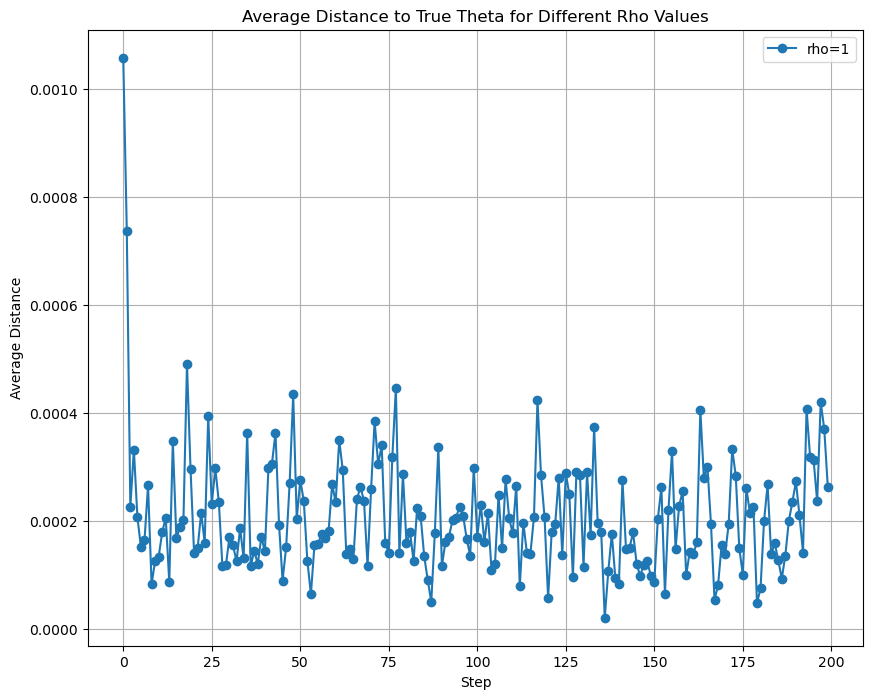

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
s = 5  # Scale parameter for uniform distribution
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m = 100  # Number of samples in the first batch
n = 1 * 10**5  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 200  # Number of steps
delta_default = 0.8  # Default probability of selecting closer points
k = 5  # Number of repetitions
rho_values = [1]  # Different rho values to test

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Optimized function to filter data points with an adjusted delta probability
def probabilistic_filter_data_optimized(data1, data2, theta_vec, delta_default, rho):
    dist1 = np.linalg.norm(data1 - theta_vec, axis=1)
    dist2 = np.linalg.norm(data2 - theta_vec, axis=1)
    
    # Adjust delta dynamically based on distance differences
    delta = np.where(np.abs(dist1 - dist2) >= rho, delta_default, 0.5)
    
    # Generate random choices for selection
    random_choices = np.random.rand(len(dist1)) < delta
    
    # Select data based on distances and random choices
    closer_data = np.where(dist1[:, None] < dist2[:, None], data1, data2)
    farther_data = np.where(dist1[:, None] >= dist2[:, None], data1, data2)
    
    # Use random choices to pick between closer and farther data
    selected_data = np.where(random_choices[:, None], closer_data, farther_data)
    return selected_data

# Generate the same initial real data for all repetitions
initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m, d))

# Dictionary to store results for different rho values
results = {}

for rho in rho_values:
    all_distances = []  # To store distances for all repetitions
    for _ in range(k):
        distances = []  # Store distances for a single repetition
        mean = compute_mean(initial_data)  # Use the same initial real data
        current_rho = rho  # Initialize rho for this repetition
        for step in range(t):
            if step > 0:
                # Subsequent steps: Generate n samples around the estimated mean from the previous step
                data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                filtered_data = probabilistic_filter_data_optimized(data1, data2, theta_vec, delta_default, current_rho)
                mean = compute_mean(filtered_data)
            
            # Update rho dynamically (this logic can be adjusted based on experiment design)
            current_rho = rho* s * np.linalg.norm(mean - theta_vec)
            #current_rho = rho
            
            # Compute distance to true theta
            distance_to_theta = np.linalg.norm(mean - theta_vec)**2
            distances.append(distance_to_theta)
        all_distances.append(distances)
    
    # Compute the average error over all repetitions for the current rho
    average_distances = np.mean(all_distances, axis=0)
    results[rho] = average_distances

# Plot the average error over steps for different rho values
plt.figure(figsize=(10, 8))
for rho, avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"rho={rho}")

plt.title("Average Distance to True Theta for Different Rho Values")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()


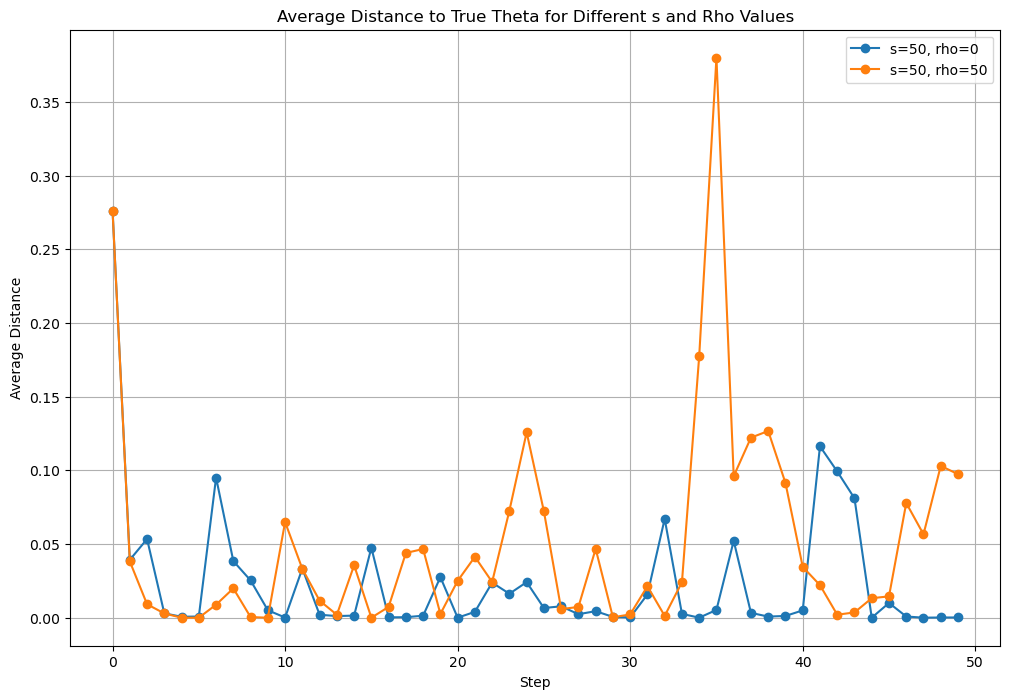

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m = 1000  # Number of samples in the first batch
n = 1 * 10**5  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 50  # Number of steps
delta_default = 0.8  # Default probability of selecting closer points
k = 1  # Number of repetitions
rho_values = [0, 1]  # Different rho values to test
s_values = [50]  # Different scale parameter values

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Optimized function to filter data points with an adjusted delta probability
def probabilistic_filter_data_optimized(data1, data2, theta_vec, delta_default, rho):
    dist1 = np.linalg.norm(data1 - theta_vec, axis=1)
    dist2 = np.linalg.norm(data2 - theta_vec, axis=1)
    
    # Adjust delta dynamically based on distance differences
    adjusted_rho = rho
    delta = np.where(np.abs(dist1 - dist2) >= adjusted_rho, delta_default, 0.5)
    
    # Generate random choices for selection
    random_choices = np.random.rand(len(dist1)) < delta
    
    # Select data based on distances and random choices
    closer_data = np.where(dist1[:, None] < dist2[:, None], data1, data2)
    farther_data = np.where(dist1[:, None] >= dist2[:, None], data1, data2)
    
    # Use random choices to pick between closer and farther data
    selected_data = np.where(random_choices[:, None], closer_data, farther_data)
    return selected_data

# Dictionary to store results for different s and rho values
results = {}

for s in s_values:
    # Generate the same initial real data for all rho values
    initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m, d))
    
    for rho in rho_values:
        rho = rho * s  # Adjust rho based on the scale parameter
        all_distances = []  # To store distances for all repetitions
        for _ in range(k):
            distances = []  # Store distances for a single repetition
            mean = compute_mean(initial_data)  # Use the same initial real data for all rho
            for step in range(t):
                if step > 0:
                    # Subsequent steps: Generate n samples around the estimated mean from the previous step
                    data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                    data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                    filtered_data = probabilistic_filter_data_optimized(data1, data2, theta_vec, delta_default, rho)
                    mean = compute_mean(filtered_data)
                
                # Compute distance to true theta
                distance_to_theta = np.linalg.norm(mean - theta_vec)**2
                distances.append(distance_to_theta)
            all_distances.append(distances)
        
        # Compute the average error over all repetitions for the current s and rho
        average_distances = np.mean(all_distances, axis=0)
        results[(s, rho)] = average_distances

# Plot the average error over steps for different s and rho values
plt.figure(figsize=(12, 8))
for (s, rho), avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"s={s}, rho={rho}")

plt.title("Average Distance to True Theta for Different s and Rho Values")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()


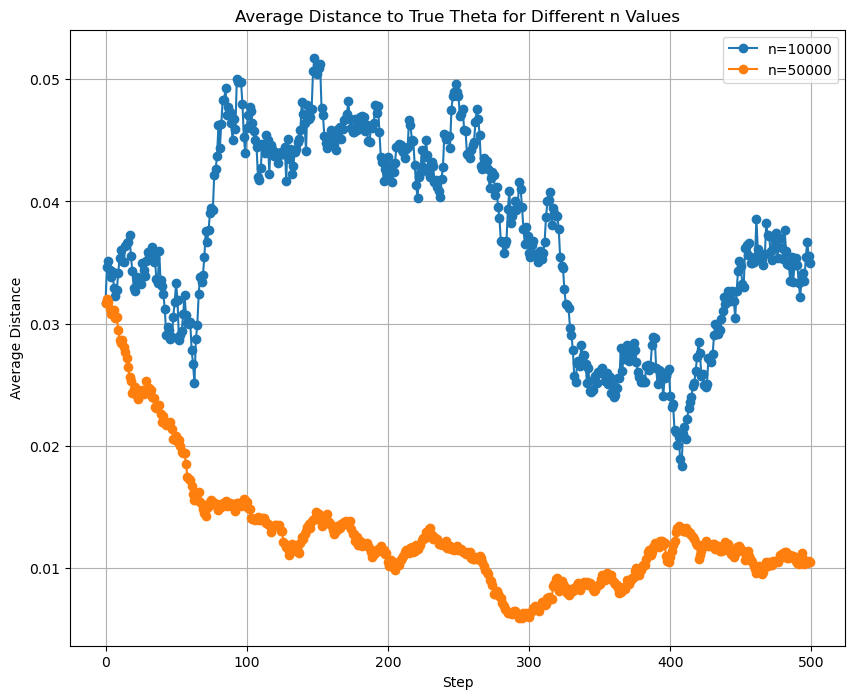

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Parameters
s = 1  # Scale parameter
r = np.sqrt(3)  # Range factor for the uniform distribution
theta = 0  # True theta (as a scalar)
m = 20  # Number of samples in the first batch
d = 5  # Dimensions
t = 500  # Number of steps
delta = 0.505  # Probability of selecting closer points
k = 10  # Number of repetitions
n_values = [10**4, 5* 10**4]  # Different values of n

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points with a fixed delta probability
def probabilistic_filter_data(data1, data2, theta_vec, delta):
    dist1 = np.linalg.norm(data1 - theta_vec, axis=1)
    dist2 = np.linalg.norm(data2 - theta_vec, axis=1)
    selected_data = []
    for i in range(len(dist1)):
        if dist1[i] < dist2[i]:
            if np.random.rand() < delta:
                selected_data.append(data1[i])
            else:
                selected_data.append(data2[i])
        else:
            if np.random.rand() < delta:
                selected_data.append(data2[i])
            else:
                selected_data.append(data1[i])
    return np.array(selected_data)

# Function to perform a single simulation repetition
def single_repetition(n, theta_vec, r, s, t, delta, d, initial_data):
    distances = []
    mean = compute_mean(initial_data)  # Use the same initial data
    for step in range(t):
        if step > 0:
            data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
            data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
            filtered_data = probabilistic_filter_data(data1, data2, theta_vec, delta)
            mean = compute_mean(filtered_data)
        distance_to_theta = np.linalg.norm(mean - theta_vec)**2
        distances.append(distance_to_theta)
    return distances

# Generate the same initial real data for all n values
initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m, d))

# Run simulations in parallel for each n value
results = {}
for n in n_values:
    all_distances = Parallel(n_jobs=-1)(
        delayed(single_repetition)(n, theta_vec, r, s, t, delta, d, initial_data) for _ in range(k)
    )
    average_distances = np.mean(all_distances, axis=0)
    results[n] = average_distances

# Plot the average error over steps for different n values
plt.figure(figsize=(10, 8))
for n, avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"n={n}")

plt.title("Average Distance to True Theta for Different n Values")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()



## use additional data to estimate the auditor

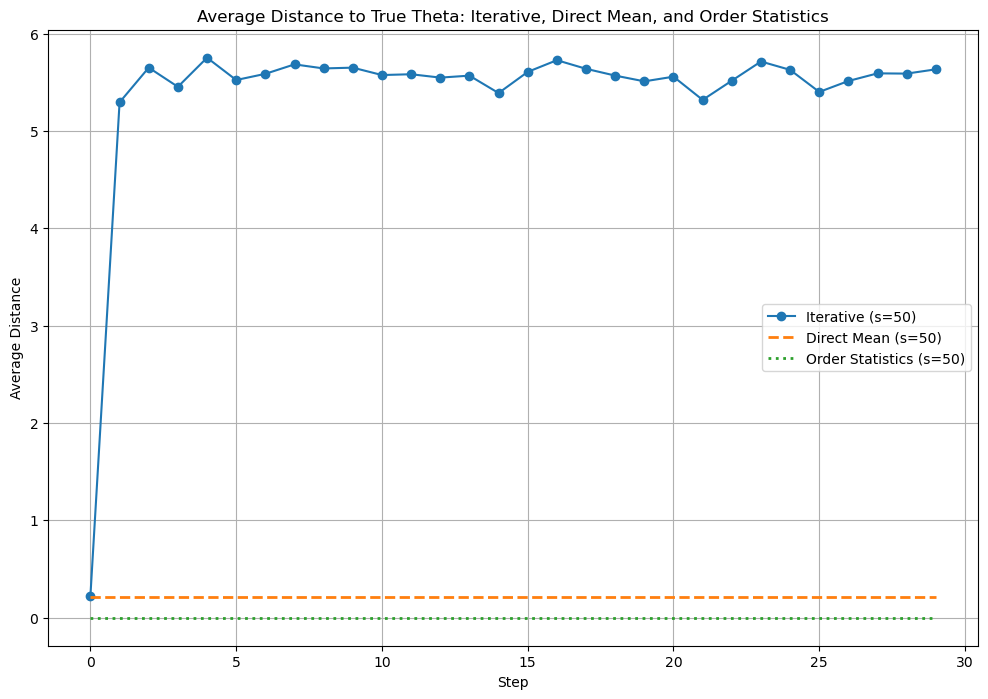

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m1 = 10000  # Number of samples in the first batch
m2 = 200  # Number of samples to compute theta_star
n = 1 * 10**5  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 30  # Number of steps
k = 30  # Number of repetitions
s_values = [50]  # Different scale parameter values
delta_default = 1  # Default probability of selecting closer points

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points based on distance to theta_star with delta
def probabilistic_filter_data(data1, data2, theta_star, delta_default):
    dist1 = np.linalg.norm(data1 - theta_star, axis=1)
    dist2 = np.linalg.norm(data2 - theta_star, axis=1)
    
    # Generate random choices for probabilistic selection
    random_choices = np.random.rand(len(dist1)) < delta_default
    
    # Select data points based on distances and random choices
    closer_data = np.where(dist1[:, None] < dist2[:, None], data1, data2)
    farther_data = np.where(dist1[:, None] >= dist2[:, None], data1, data2)
    selected_data = np.where(random_choices[:, None], closer_data, farther_data)
    return selected_data

# Initialize dictionaries to store results
results = {}
direct_errors = {}
order_stat_errors = {}

for s in s_values:
    all_iterative_distances = []
    all_direct_errors = []
    all_order_stat_errors = []
    
    for _ in range(k):  # Repeat the entire simulation process k times
        # Generate the same initial real data for all repetitions
        initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m1, d))
        additional_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m2, d))
        
        # Combine m1 + m2 data for direct estimation of theta
        combined_data = np.vstack([initial_data, additional_data])
        direct_mean = compute_mean(combined_data)
        direct_error = np.linalg.norm(direct_mean - theta_vec)**2  # Error for direct mean estimate
        
        # Order statistics estimator (average of min and max values)
        order_stat_min = np.min(combined_data, axis=0)
        order_stat_max = np.max(combined_data, axis=0)
        order_stat_mean = (order_stat_min + order_stat_max) / 2
        order_stat_error = np.linalg.norm(order_stat_mean - theta_vec)**2  # Error for order statistics estimate
        
        # Compute initial theta_star using additional m2 samples
        theta_star = compute_mean(additional_data)
        
        distances = []  # Store distances for a single repetition
        mean = compute_mean(initial_data)  # Use the same initial real data
        for step in range(t):
            if step > 0:
                # Subsequent steps: Generate n samples around the estimated mean from the previous step
                data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                filtered_data = probabilistic_filter_data(data1, data2, theta_star, delta_default)
                mean = compute_mean(filtered_data)
            
            # Compute distance to true theta
            distance_to_theta = np.linalg.norm(mean - theta_vec)**2
            distances.append(distance_to_theta)
        
        # Append the distances and errors to their respective lists
        all_iterative_distances.append(distances)
        all_direct_errors.append(direct_error)
        all_order_stat_errors.append(order_stat_error)
    
    # Compute averages over k repetitions
    avg_iterative_distances = np.mean(all_iterative_distances, axis=0)
    avg_direct_error = np.mean(all_direct_errors)
    avg_order_stat_error = np.mean(all_order_stat_errors)
    
    # Store the results for plotting
    results[s] = avg_iterative_distances
    direct_errors[s] = [avg_direct_error] * t  # Constant across all steps
    order_stat_errors[s] = [avg_order_stat_error] * t  # Constant across all steps

# Plot the average error over steps for different s values
plt.figure(figsize=(12, 8))
for s, avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"Iterative (s={s})")

for s, direct_error in direct_errors.items():
    plt.plot(range(t), direct_error, linestyle='--', label=f"Direct Mean (s={s})", linewidth=2)

for s, order_stat_error in order_stat_errors.items():
    plt.plot(range(t), order_stat_error, linestyle=':', label=f"Order Statistics (s={s})", linewidth=2)

plt.title("Average Distance to True Theta: Iterative, Direct Mean, and Order Statistics")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()


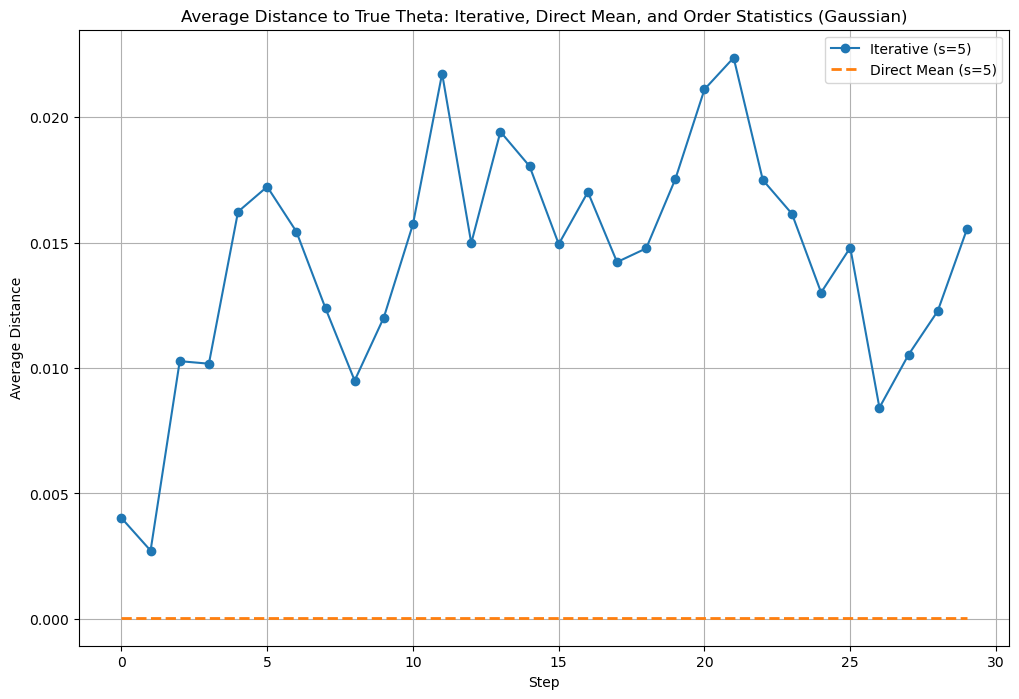

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
theta = 0  # True theta (as a scalar)
m1 = 1000  # Number of samples in the first batch
m2 = 600  # Number of samples to compute theta_star
n = 1 * 10**5  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 30  # Number of steps
k = 1  # Number of repetitions
s_values = [5]  # Different standard deviations for Gaussian distribution
delta_default = 1  # Default probability of selecting closer points

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points based on distance to theta_star with delta
def probabilistic_filter_data(data1, data2, theta_star, delta_default):
    dist1 = np.linalg.norm(data1 - theta_star, axis=1)
    dist2 = np.linalg.norm(data2 - theta_star, axis=1)
    
    # Generate random choices for probabilistic selection
    random_choices = np.random.rand(len(dist1)) < delta_default
    
    # Select data points based on distances and random choices
    closer_data = np.where(dist1[:, None] < dist2[:, None], data1, data2)
    farther_data = np.where(dist1[:, None] >= dist2[:, None], data1, data2)
    selected_data = np.where(random_choices[:, None], closer_data, farther_data)
    return selected_data

# Dictionary to store results for different s values
results = {}
direct_errors = {}  # To store direct mean estimate errors
order_stat_errors = {}  # To store order statistics estimate errors

for s in s_values:
    # Generate the same initial real data for all repetitions
    initial_data = np.random.normal(loc=theta_vec, scale=s, size=(m1, d))
    additional_data = np.random.normal(loc=theta_vec, scale=s, size=(m2, d))
    
    # Combine m1 + m2 data for direct estimation of theta
    combined_data = np.vstack([initial_data, additional_data])
    direct_mean = compute_mean(combined_data)
    direct_error = np.linalg.norm(direct_mean - theta_vec)**2  # Error for direct mean estimate
    
    # Order statistics estimator (average of min and max values)
    order_stat_min = np.min(combined_data, axis=0)
    order_stat_max = np.max(combined_data, axis=0)
    order_stat_mean = (order_stat_min + order_stat_max) / 2
    order_stat_error = np.linalg.norm(order_stat_mean - theta_vec)**2  # Error for order statistics estimate
    
    # Store the direct error and order statistics error for plotting
    direct_errors[s] = [direct_error] * t  # Constant across all steps
    order_stat_errors[s] = [order_stat_error] * t  # Constant across all steps
    
    # Compute initial theta_star using additional m2 samples
    theta_star = compute_mean(additional_data)
    
    all_distances = []  # To store distances for all repetitions
    for _ in range(k):
        distances = []  # Store distances for a single repetition
        mean = compute_mean(initial_data)  # Use the same initial real data
        for step in range(t):
            if step > 0:
                # Subsequent steps: Generate n samples around the estimated mean from the previous step
                data1 = np.random.normal(loc=mean, scale=s, size=(n, d))
                data2 = np.random.normal(loc=mean, scale=s, size=(n, d))
                filtered_data = probabilistic_filter_data(data1, data2, theta_star, delta_default)
                mean = compute_mean(filtered_data)
            
            # Compute distance to true theta
            distance_to_theta = np.linalg.norm(mean - theta_vec)**2
            distances.append(distance_to_theta)
        all_distances.append(distances)
    
    # Compute the average error over all repetitions for the current s
    average_distances = np.mean(all_distances, axis=0)
    results[s] = average_distances

# Plot the average error over steps for different s values
plt.figure(figsize=(12, 8))
for s, avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"Iterative (s={s})")

for s, direct_error in direct_errors.items():
    plt.plot(range(t), direct_error, linestyle='--', label=f"Direct Mean (s={s})", linewidth=2)

plt.title("Average Distance to True Theta: Iterative, Direct Mean, and Order Statistics (Gaussian)")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()


Initial Mean: [0.12940873], Theta Star: [0.12457723]


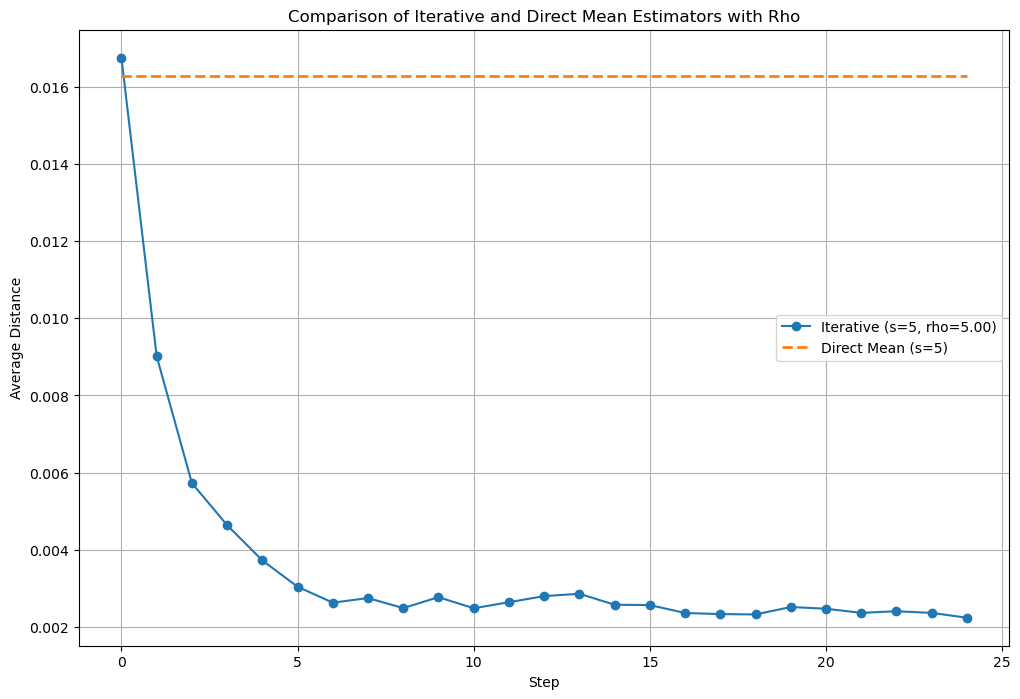

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m1 = 1000  # Number of samples in the first batch
m2 = 600  # Number of samples in the additional batch
n = 5 * 10**6  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 25  # Number of steps
delta_default = 1  # Default probability of selecting closer points
k = 1  # Number of repetitions
s_values = [5]  # Different scale parameter values
rho_values = [1]  # Different rho values to test

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points based on distance to theta with delta and rho
def probabilistic_filter_data(data1, data2, theta, delta_default, rho):
    dist1 = np.linalg.norm(data1 - theta, axis=1)
    dist2 = np.linalg.norm(data2 - theta, axis=1)
    
    # Adjust delta dynamically based on distance differences
    adjusted_delta = np.where(np.abs(dist1 - dist2) >= rho, delta_default, 0.5)
    
    # Generate random choices for probabilistic selection
    random_choices = np.random.rand(len(dist1)) < adjusted_delta
    
    # Select data points based on distances and random choices
    closer_data = np.where(dist1[:, None] < dist2[:, None], data1, data2)
    farther_data = np.where(dist1[:, None] >= dist2[:, None], data1, data2)
    selected_data = np.where(random_choices[:, None], closer_data, farther_data)
    return selected_data

# Initialize storage for final results
results = {}
direct_errors = {}

for s in s_values:
    all_direct_errors = []
    all_iterative_distances = []

    for _ in range(k):  # Repeat the entire process for k runs
        # Generate the same initial data for all repetitions
        initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m1, d))
        additional_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m2, d))
        
        # Direct mean estimation using m1 + m2
        combined_data = np.vstack([initial_data, additional_data])
        direct_mean = compute_mean(combined_data)
        direct_error = np.linalg.norm(direct_mean - theta_vec)**2
        all_direct_errors.append(direct_error)
        
        for rho in rho_values:
            distances = []  # Store distances for a single iteration
            mean = compute_mean(initial_data)  # Use the same initial data for all repetitions
            theta_star = compute_mean(additional_data)  # Compute theta_star using additional data
            print(f"Initial Mean: {mean}, Theta Star: {theta_star}")
            rho_adjusted = rho * s  # Adjust rho based on the scale parameter
            
            # Compute the initial distance for the first step
            initial_distance = np.linalg.norm(mean - theta_vec)**2
            distances.append(initial_distance)
            
            for step in range(1, t):  # Start from step 1
                # Generate n samples around the current mean
                data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                theta_hat = theta_vec + 0.05  # Randomly perturb the true theta
                filtered_data = probabilistic_filter_data(data1, data2, theta_hat, delta_default, rho_adjusted)
                mean = compute_mean(filtered_data)
                
                # Compute distance to true theta
                distance_to_theta = np.linalg.norm(mean - theta_vec)**2
                distances.append(distance_to_theta)
            
            all_iterative_distances.append(distances)
    
    # Compute the average over all repetitions
    average_direct_error = np.mean(all_direct_errors)
    average_iterative_distances = np.mean(all_iterative_distances, axis=0)
    
    # Store the results
    direct_errors[s] = [average_direct_error] * t
    results[(s, rho_adjusted)] = average_iterative_distances

# Plot the average error over steps for different s and rho values
plt.figure(figsize=(12, 8))

# Plot iterative method
for (s, rho), avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"Iterative (s={s}, rho={rho:.2f})")

# Plot direct mean method
for s, avg_error in direct_errors.items():
    plt.plot(range(t), avg_error, linestyle='--', label=f"Direct Mean (s={s})", linewidth=2)

plt.title("Comparison of Iterative and Direct Mean Estimators with Rho")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()


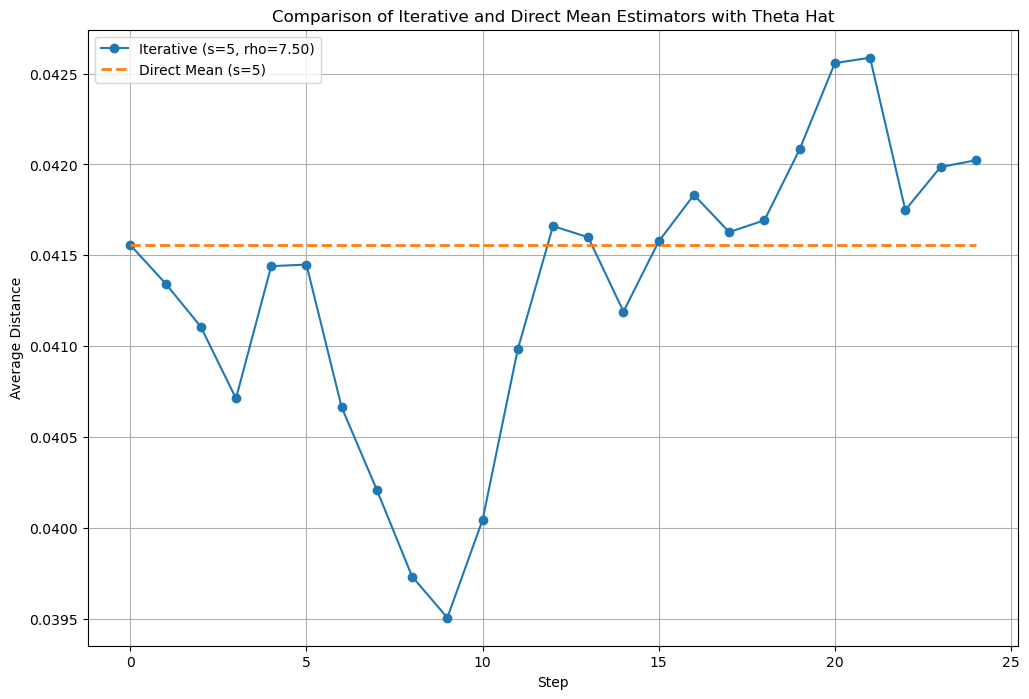

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m = 1000  # Number of samples in the first batch
n = 1 * 10**6  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 25  # Number of steps
delta_default = 0.8  # Default probability of selecting closer points
repetitions = 10  # Number of repetitions
s_values = [5]  # Different scale parameter values
rho_values = [1.5]  # Different rho values to test

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points based on distance to theta_hat
def probabilistic_filter_data(data1, data2, theta_hat, delta_default, rho):
    dist1 = np.linalg.norm(data1 - theta_hat, axis=1)
    dist2 = np.linalg.norm(data2 - theta_hat, axis=1)
    
    # Adjust delta dynamically based on distance differences
    adjusted_delta = np.where(np.abs(dist1 - dist2) >= rho, delta_default, 0.5)
    
    # Generate random choices for probabilistic selection
    random_choices = np.random.rand(len(dist1)) < adjusted_delta
    
    # Select data points based on distances and random choices
    closer_data = np.where(dist1[:, None] < dist2[:, None], data1, data2)
    farther_data = np.where(dist1[:, None] >= dist2[:, None], data1, data2)
    selected_data = np.where(random_choices[:, None], closer_data, farther_data)
    return selected_data

# Initialize storage for final results
results = {}
direct_errors = {}

for s in s_values:
    all_direct_errors = []
    all_iterative_distances = []

    for _ in range(repetitions):  # Repeat the entire process for multiple runs
        # Generate initial data
        initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m, d))
        
        # Compute the initial estimator (theta_hat)
        theta_hat = compute_mean(initial_data)
        direct_error = np.linalg.norm(theta_hat - theta_vec)**2
        all_direct_errors.append(direct_error)
        
        for rho in rho_values:
            rho_adjusted = rho * s  # Adjust rho based on the scale parameter
            distances = []  # Store distances for a single iteration
            mean = theta_hat  # Use the initial mean as the starting point
            
            # Compute the initial distance for the first step
            initial_distance = np.linalg.norm(mean - theta_vec)**2
            distances.append(initial_distance)
            
            for step in range(1, t):  # Start from step 1
                # Generate n samples around the current mean
                data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                filtered_data = probabilistic_filter_data(data1, data2, theta_hat, delta_default, rho_adjusted)
                mean = compute_mean(filtered_data)
                
                # Compute distance to true theta
                distance_to_theta = np.linalg.norm(mean - theta_vec)**2
                distances.append(distance_to_theta)
            
            all_iterative_distances.append(distances)
    
    # Compute the average over all repetitions
    average_direct_error = np.mean(all_direct_errors)
    average_iterative_distances = np.mean(all_iterative_distances, axis=0)
    
    # Store the results
    direct_errors[s] = [average_direct_error] * t
    results[(s, rho_adjusted)] = average_iterative_distances

# Plot the average error over steps for different s and rho values
plt.figure(figsize=(12, 8))

# Plot iterative method
for (s, rho), avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"Iterative (s={s}, rho={rho:.2f})")

# Plot direct mean method
for s, avg_error in direct_errors.items():
    plt.plot(range(t), avg_error, linestyle='--', label=f"Direct Mean (s={s})", linewidth=2)

plt.title("Comparison of Iterative and Direct Mean Estimators with Theta Hat")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()


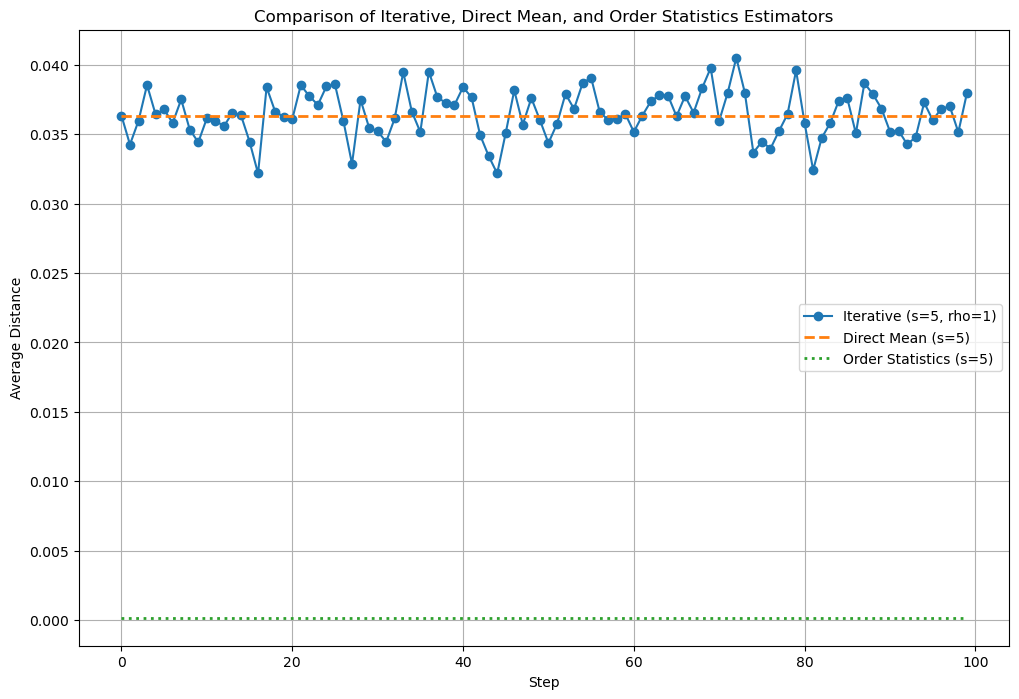

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m = 1000  # Number of samples in the first batch
n = 1 * 10**6  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 100  # Number of steps
delta_default = 0.9  # Default probability of selecting closer points
repetitions = 1  # Number of repetitions
s_values = [5]  # Different scale parameter values
rho_values = [1]  # Different rho values to test

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points based on distance to theta_hat
def probabilistic_filter_data(data1, data2, theta_hat, delta_default, rho):
    dist1 = np.linalg.norm(data1 - theta_hat, axis=1)
    dist2 = np.linalg.norm(data2 - theta_hat, axis=1)
    
    # Adjust delta dynamically based on distance differences
    adjusted_delta = np.where(np.abs(dist1 - dist2) >= rho, delta_default, 0.5)
    
    # Generate random choices for probabilistic selection
    random_choices = np.random.rand(len(dist1)) < adjusted_delta
    
    # Select data points based on distances and random choices
    closer_data = np.where(dist1[:, None] < dist2[:, None], data1, data2)
    farther_data = np.where(dist1[:, None] >= dist2[:, None], data1, data2)
    selected_data = np.where(random_choices[:, None], closer_data, farther_data)
    return selected_data

# Initialize storage for final results
results = {}
direct_errors = {}
order_stat_errors = {}

for s in s_values:
    all_direct_errors = []
    all_iterative_distances = []
    all_order_stat_errors = []

    for _ in range(repetitions):  # Repeat the entire process for multiple runs
        # Generate initial data
        initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m, d))
        
        # Compute the initial estimator (theta_hat)
        theta_hat = compute_mean(initial_data)
        direct_error = np.linalg.norm(theta_hat - theta_vec)**2
        all_direct_errors.append(direct_error)
        
        # Order statistics estimator (average of max and min)
        order_stat_min = np.min(initial_data, axis=0)
        order_stat_max = np.max(initial_data, axis=0)
        order_stat_mean = (order_stat_min + order_stat_max) / 2
        order_stat_error = np.linalg.norm(order_stat_mean - theta_vec)**2
        all_order_stat_errors.append(order_stat_error)
        
        for rho in rho_values:
            distances = []  # Store distances for a single iteration
            mean = theta_hat  # Use the initial mean as the starting point
            
            # Compute the initial distance for the first step
            initial_distance = np.linalg.norm(mean - theta_vec)**2
            distances.append(initial_distance)
            
            for step in range(1, t):  # Start from step 1
                # Generate n samples around the current mean
                data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                filtered_data = probabilistic_filter_data(data1, data2, theta_hat, delta_default, rho)
                mean = compute_mean(filtered_data)
                
                # Compute distance to true theta
                distance_to_theta = np.linalg.norm(mean - theta_vec)**2
                distances.append(distance_to_theta)
            
            all_iterative_distances.append(distances)
    
    # Compute the average over all repetitions
    average_direct_error = np.mean(all_direct_errors)
    average_order_stat_error = np.mean(all_order_stat_errors)
    average_iterative_distances = np.mean(all_iterative_distances, axis=0)
    
    # Store the results using (s, rho)
    direct_errors[s] = [average_direct_error] * t
    order_stat_errors[s] = [average_order_stat_error] * t
    results[(s, rho)] = average_iterative_distances

# Plot the average error over steps for different s and rho values
plt.figure(figsize=(12, 8))

# Plot iterative method
for (s, rho), avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"Iterative (s={s}, rho={rho})")

# Plot direct mean method
for s, avg_error in direct_errors.items():
    plt.plot(range(t), avg_error, linestyle='--', label=f"Direct Mean (s={s})", linewidth=2)

# Plot order statistics method
for s, avg_error in order_stat_errors.items():
    plt.plot(range(t), avg_error, linestyle=':', label=f"Order Statistics (s={s})", linewidth=2)

plt.title("Comparison of Iterative, Direct Mean, and Order Statistics Estimators")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()


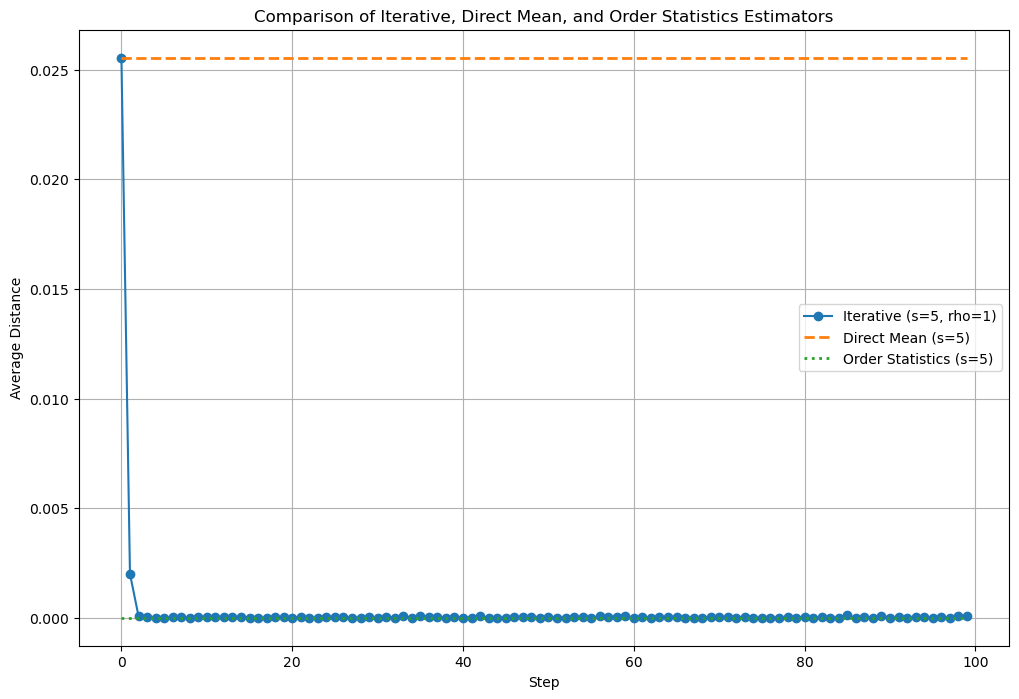

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m = 1000  # Number of samples in the first batch
n = 1 * 10**6  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 100  # Number of steps
delta_default = 0.9  # Default probability of selecting closer points
repetitions = 1  # Number of repetitions
s_values = [5]  # Different scale parameter values
rho_values = [1]  # Different rho values to test

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points based on distance to theta_hat
def probabilistic_filter_data(data1, data2, theta_hat, delta_default, rho):
    dist1 = np.linalg.norm(data1 - theta_hat, axis=1)
    dist2 = np.linalg.norm(data2 - theta_hat, axis=1)
    
    # Adjust delta dynamically based on distance differences
    adjusted_delta = np.where(np.abs(dist1 - dist2) >= rho, delta_default, 0.5)
    
    # Generate random choices for probabilistic selection
    random_choices = np.random.rand(len(dist1)) < adjusted_delta
    
    # Select data points based on distances and random choices
    closer_data = np.where(dist1[:, None] < dist2[:, None], data1, data2)
    farther_data = np.where(dist1[:, None] >= dist2[:, None], data1, data2)
    selected_data = np.where(random_choices[:, None], closer_data, farther_data)
    return selected_data

# Initialize storage for final results
results = {}
direct_errors = {}
order_stat_errors = {}

for s in s_values:
    all_direct_errors = []
    all_iterative_distances = []
    all_order_stat_errors = []

    for _ in range(repetitions):  # Repeat the entire process for multiple runs
        # Generate initial data
        initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m, d))
        
        # Compute the initial estimator (theta_hat)
        theta_hat = compute_mean(initial_data)
        direct_error = np.linalg.norm(theta_hat - theta_vec)**2
        all_direct_errors.append(direct_error)
        
        # Order statistics estimator (average of max and min)
        order_stat_min = np.min(initial_data, axis=0)
        order_stat_max = np.max(initial_data, axis=0)
        order_stat_mean = (order_stat_min + order_stat_max) / 2
        order_stat_error = np.linalg.norm(order_stat_mean - theta_vec)**2
        all_order_stat_errors.append(order_stat_error)
        
        for rho in rho_values:
            distances = []  # Store distances for a single iteration
            mean = theta_hat  # Use the initial mean as the starting point
            
            # Compute the initial distance for the first step
            initial_distance = np.linalg.norm(mean - theta_vec)**2
            distances.append(initial_distance)
            
            for step in range(1, t):  # Start from step 1
                # Generate n samples around the current mean
                data1 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                data2 = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(n, d))
                filtered_data = probabilistic_filter_data(data1, data2, theta_vec, delta_default, rho)
                mean = compute_mean(filtered_data)
                
                # Compute distance to true theta
                distance_to_theta = np.linalg.norm(mean - theta_vec)**2
                distances.append(distance_to_theta)
            
            all_iterative_distances.append(distances)
    
    # Compute the average over all repetitions
    average_direct_error = np.mean(all_direct_errors)
    average_order_stat_error = np.mean(all_order_stat_errors)
    average_iterative_distances = np.mean(all_iterative_distances, axis=0)
    
    # Store the results using (s, rho)
    direct_errors[s] = [average_direct_error] * t
    order_stat_errors[s] = [average_order_stat_error] * t
    results[(s, rho)] = average_iterative_distances

# Plot the average error over steps for different s and rho values
plt.figure(figsize=(12, 8))

# Plot iterative method
for (s, rho), avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"Iterative (s={s}, rho={rho})")

# Plot direct mean method
for s, avg_error in direct_errors.items():
    plt.plot(range(t), avg_error, linestyle='--', label=f"Direct Mean (s={s})", linewidth=2)

# Plot order statistics method
for s, avg_error in order_stat_errors.items():
    plt.plot(range(t), avg_error, linestyle=':', label=f"Order Statistics (s={s})", linewidth=2)

plt.title("Comparison of Iterative, Direct Mean, and Order Statistics Estimators")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()
